# CSC 730 Assignment 8 - Active Learning
## Mangesh Sakordekar

### Imports

In [1]:
import numpy as np
from keras.datasets import mnist
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import random
import matplotlib as mpl
from sklearn.ensemble import IsolationForest as iforest
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import OPTICS
from sklearn.mixture import GaussianMixture

### Data Processing

In [2]:
(X, y), _ = mnist.load_data()
X = X.reshape((len(y), 28*28))
X = X[:6000,:]
y = y[:6000]

In [3]:
X_norm = X/255.0
X_scaled = StandardScaler().fit_transform(X_norm) 

In [4]:
X_train = X_scaled[0:5000, :]
y_train = y[0:5000]
X_test = X_scaled[5000:,:]
y_test = y[5000:]

### Strategies

In [5]:
class Strategy1():

    def __init__(self, X_U):
        i_f = iforest(random_state=0).fit(X_U)
        scores = i_f.score_samples(X_U)
        self._size = len(X_U)
        self._lvl = 2
        self._counter = 0
        self._rank = np.argsort(scores)[::-1]
        self._q = [self._size // 2]
        
    def get_query(self):
        ind = self._q.pop(0)
        self.append(ind - (self._size // (self._lvl *2)))
        self.append(ind + (self._size // (self._lvl *2)))

        if self._counter == self._lvl:
            self._counter = 0
            self._lvl *= 2

        return self._rank[ind]
            

    def append(self, ele):
        self._q.append(ele)
        self._counter += 1

In [6]:
class Strategy2:
    def __init__(self, X):
        X_tsne = self._tsne(X)
        self._q = self._make_clusters(X_tsne)
        self._ind = 0

    def _tsne(self, X):
        tsne = TSNE(n_components=2, random_state=42)
        return tsne.fit_transform(X)

    def _make_clusters(self, X):
        clusterer = OPTICS(min_samples=3, xi=0.005, min_cluster_size=30)
        clusters = clusterer.fit_predict(X)

        cls = []
        for i in range(-1, np.max(clusters)+1):
            temp = [j for j in range(0, len(clusters)) if clusters[j] == i]
            cls.append(temp)

        return cls

    def get_query(self):
        index = self._q[self._ind].pop(0)
        self._ind = (self._ind + 1) % len(self._q)

        return index

In [7]:
 class Strategy3:
     def __init__(self, X, classifier):
         self._classifier = classifier
         self._X = X
         
     def get_query(self):
         y_proba = self._classifier.get_probs(self._X)
         ind = np.argmin(np.max(y_proba, axis=1))
         return ind

In [8]:
class Strategy4:
    def __init__(self, X, num_clusters=50):
        self._q = self._make_clusters(X, num_clusters)
        self._ind = 0

    def _make_clusters(self, X, num_clusters):
        gmm = GaussianMixture(n_components=num_clusters, random_state=42)
        gmm.fit(X)
        clusters = gmm.predict(X)

        cls = []
        for i in range(0, num_clusters):
            temp = [j for j in range(0, len(clusters)) if clusters[j] == i]
            cls.append(temp)

        return cls

    def get_query(self):
        index = self._q[self._ind].pop(0)
        self._ind = (self._ind + 1) % len(self._q)
        while len(self._q[self._ind]) == 0:
            self._ind = (self._ind + 1) % len(self._q)

        return index

In [9]:
class RandomStrategy:
    def __init__(self, l):
        self._q = list(range(0,l))
        random.shuffle(self._q)

    def get_query(self):
        return self._q.pop(0)

### Class Definitions

In [10]:
class Classifier:
    
    def __init__(self):
        self._clf = None
        self._clf = MLPClassifier(hidden_layer_sizes=(128, 32), activation='relu', solver='adam', alpha=0.0001,
                    learning_rate='constant', max_iter=1000, random_state=42)
        

    def train(self, X_data, y_lbls):
        
        _ = self._clf.fit(X_data, y_lbls)

    def predict(self, X_data):
        return self._clf.predict(X_data)

    def get_probs(self, X):
        return self._clf.predict_proba(X)

In [11]:
class Metrics:
    def get_accuracy(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        accuracy = np.trace(cm) / np.sum(cm)
        return accuracy, cm

In [12]:
class Oracle:

    def __init__(self, y):
        self._y = y

    def get_label(self, index):
        return y[index]

### Active Learner Implementation and Runs

In [13]:
class ActiveLearner:
    _metrics = Metrics()
    def __init__(self, X, X_test, y_test, strategy, classifier, oracle, mq = 400):
        self._strategy = strategy
        self._classifier = classifier
        self._oracle = oracle
        self._X = X
        self._X_test = X_test
        self._y_test = y_test
        self._max_queries = mq

    def learn(self, threshold = 0.6):
        
        X_L = np.empty((0,self._X.shape[1]))
        y_L = np.empty((0,))
        accuracies = []
        cms =  []
        accuracy = 0.0
        query_count = 0
        
        while accuracy < threshold and query_count < self._max_queries:

            query_count += 1

            indx = self._strategy.get_query()
            X_L = np.concatenate((X_L, self._X[indx,:].reshape((1, self._X.shape[1]))))
            y_L = np.concatenate((y_L, self._oracle.get_label(indx).reshape((1,))))
    
            self._classifier.train(X_L, y_L)
            y_pred = self._classifier.predict(self._X_test)
            
            accuracy, cm = self._metrics.get_accuracy(self._y_test, y_pred)
            accuracies.append(accuracy)
            cms.append(cm)
            

        return accuracies, cms


In [14]:
strat = RandomStrategy(len(y_train))
classify = Classifier()
oracle = Oracle(y_train)
base_al = ActiveLearner(X_train, X_test, y_test, strat, classify, oracle)
acc_base, cm_base = base_al.learn(0.95)

In [15]:
strat1 = Strategy1(X_train)
classify1 = Classifier()
s1_al = ActiveLearner(X_train, X_test, y_test, strat1, classify1, oracle)
acc_1, cm_1 = s1_al.learn(0.95)

In [16]:
strat2 = Strategy2(X_train)
classify2 = Classifier()
s2_al = ActiveLearner(X_train, X_test, y_test, strat2, classify2, oracle)
acc_2, cm_2 = s2_al.learn(0.95)

In [17]:
classify3 = Classifier()
classify3.train(np.zeros((1, X_train.shape[1])), np.zeros((1)))
strat3 = Strategy3(X_train, classify3)
s3_al = ActiveLearner(X_train, X_test, y_test, strat3, classify3, oracle)
acc_3, cm_3 = s3_al.learn(0.95)

In [18]:
strat4 = Strategy4(X_train)
classify4 = Classifier()
s4_al = ActiveLearner(X_train, X_test, y_test, strat4, classify4, oracle)
acc_4, cm_4 = s4_al.learn(0.95)

### Plots

In [19]:
def showCMs(images, labels):
    fig = plt.figure(figsize=(20, 5))
    num_imgs = len(images)
    for i in range(num_imgs):
        a=fig.add_subplot(1,num_imgs,i+1)
        plt.imshow(images[i])
        plt.title(labels[i] + ' (' + str(np.trace(images[i])/np.sum(images[i])) + ')')
        plt.axis('off')

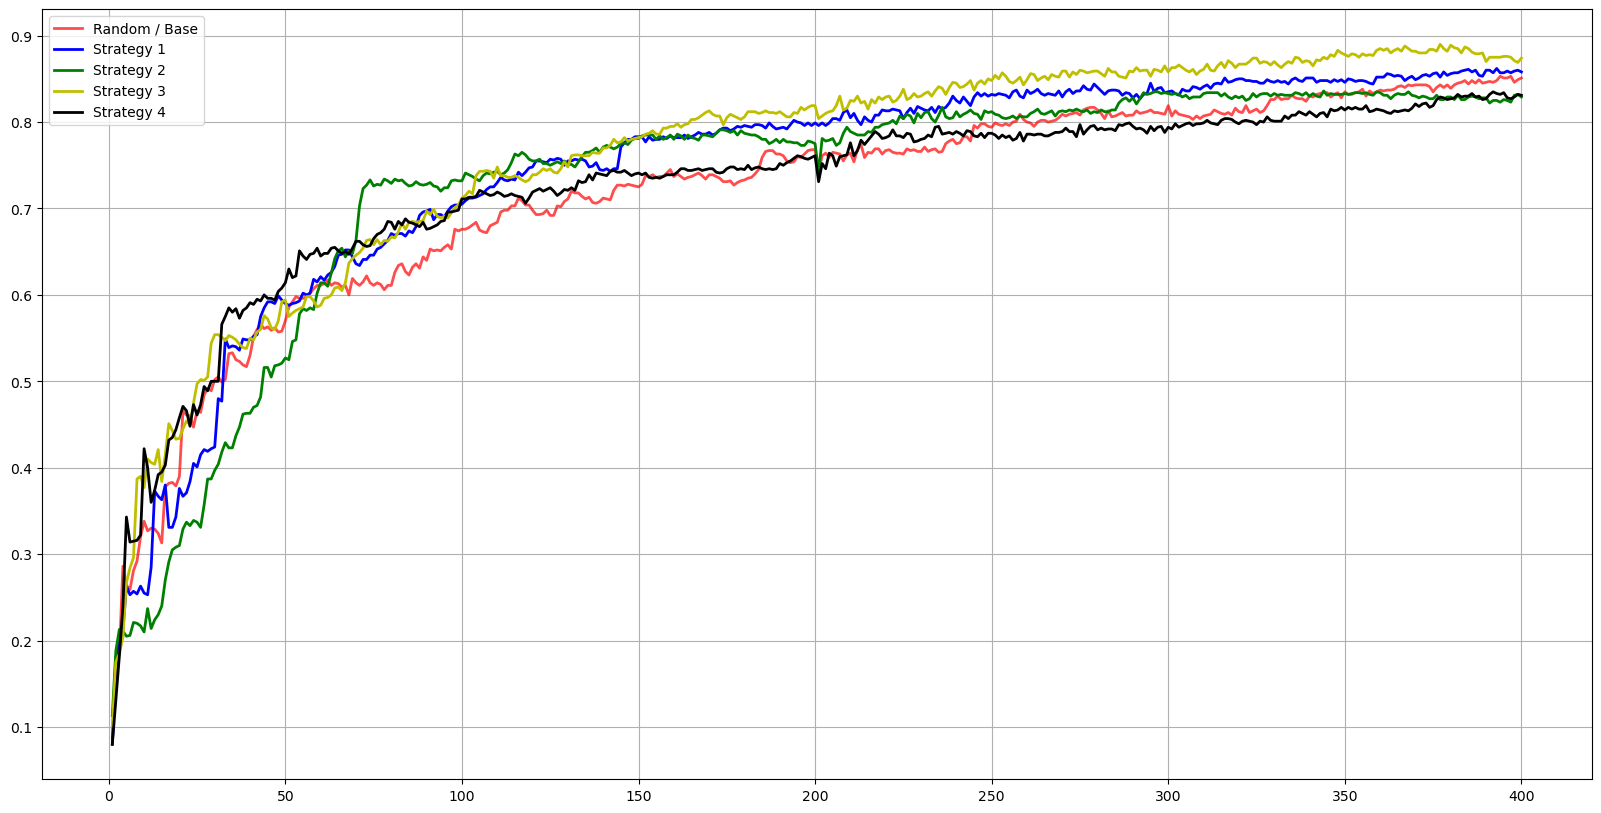

In [20]:
plt.figure(figsize=(20,10))
plt.plot([i for i in range(1, len(acc_base)+1)], acc_base, 'r-', label='Random / Base', linewidth=2, alpha = 0.7)
plt.plot([i for i in range(1, len(acc_1)+1)], acc_1, 'b-', label='Strategy 1', linewidth=2)
plt.plot([i for i in range(1, len(acc_2)+1)], acc_2, 'g-', label='Strategy 2', linewidth=2)
plt.plot([i for i in range(1, len(acc_3)+1)], acc_3, 'y-', label='Strategy 3', linewidth=2)
plt.plot([i for i in range(1, len(acc_4)+1)], acc_4, 'k-', label='Strategy 4', linewidth=2)
plt.grid()
plt.legend()

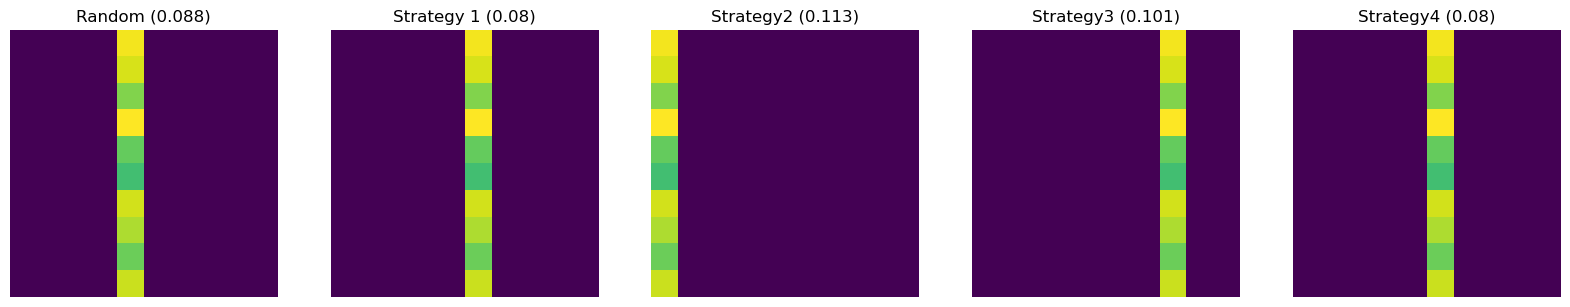

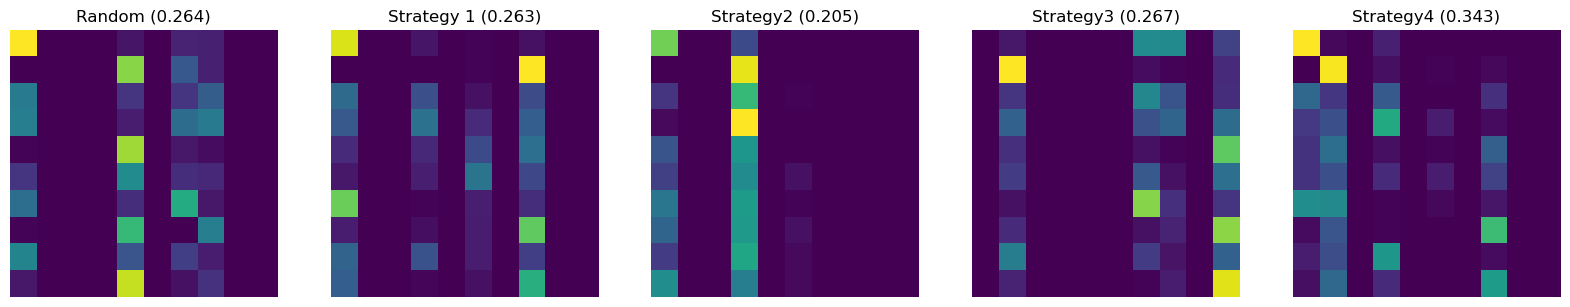

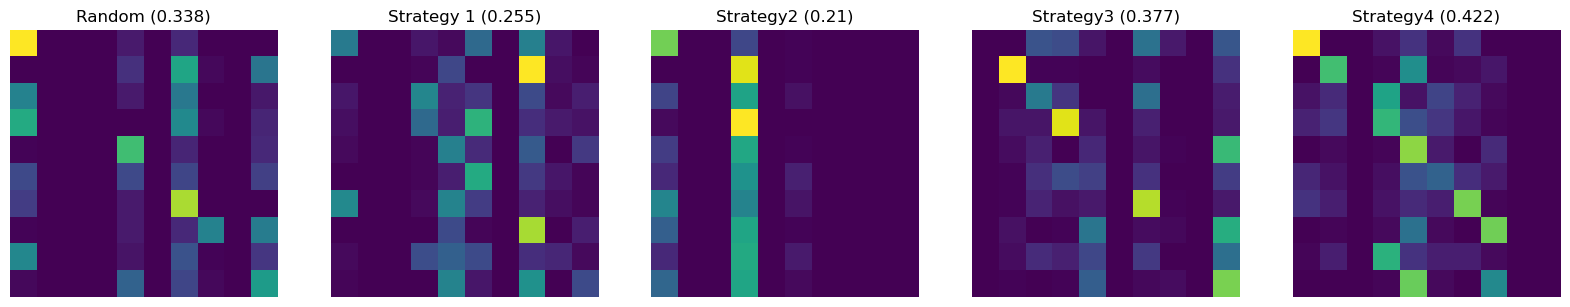

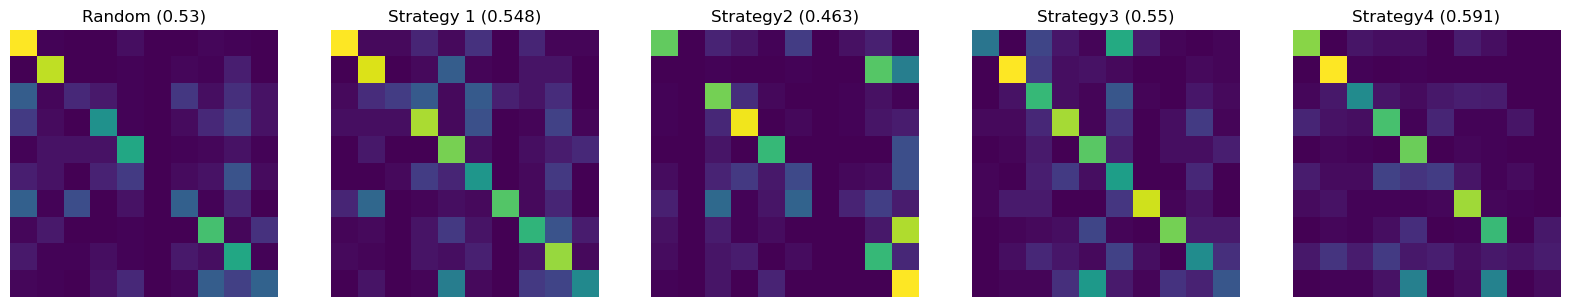

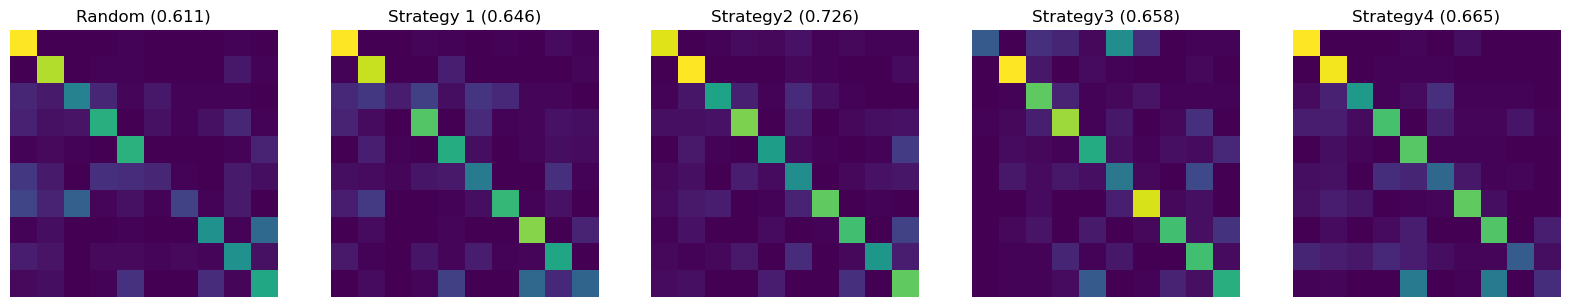

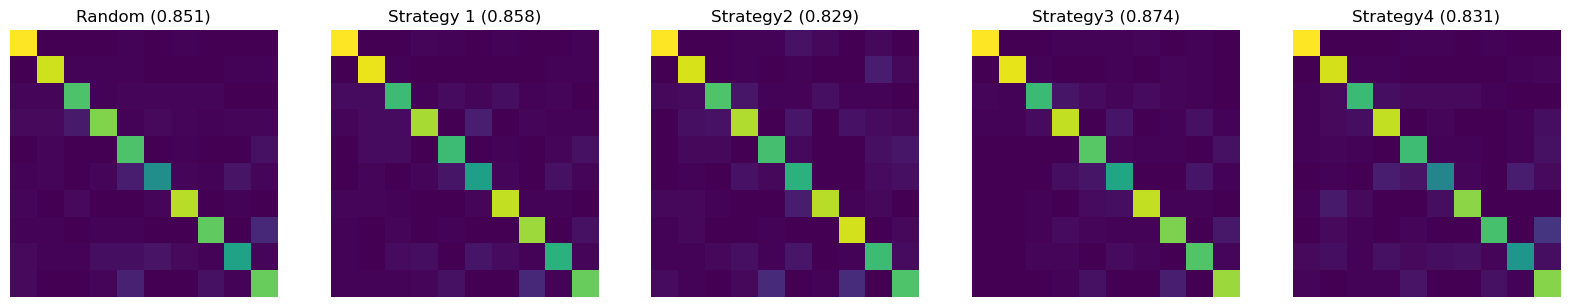

In [27]:
indices = [0, 4, 9, 39, 74, 399]
for i in indices:
    showCMs([cm_base[i], cm_1[i], cm_2[i], cm_3[i], cm_4[i]], ['Random', 'Strategy 1', 'Strategy2', 'Strategy3', 'Strategy4'])